# using very little data for image classification by the strategies of data augmentation and fine-tune

Part of the code is referred to the [blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

the outline will go as follows:
- collection data from the kaggle [cats_and_dogs](https://www.kaggle.com/c/dogs-vs-cats/data) and use only 2800 data points, where `2000` for training and validation and `800` for testing.
- training a small network from scratch as a baseline
- apply the data augmentation
- using the bottleneck features of a pre-trained network
- fine-tuning the top layers of a pre-trained network

The main purpose is to familar with some Keras features:
- `fit_generator` for training Keras a model using Python data generators
- `ImageDataGenerator` for real-time data augmentation
- `layer freezing and` model fine-tuning

## 1. Packages

In [79]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras import backend as K
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import applications
from tensorflow.keras.preprocessing import image

## 2. data preparation

a training data directory and validation data directory containing one subdirectory per image class, filled with .png or .jpg images:

data/<br>
&emsp;&emsp;train/<br>
&emsp;&emsp;&emsp;&emsp;cats/<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;cat001.jpg<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;cat002.jpg<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;...<br>
&emsp;&emsp;&emsp;&emsp;dogs/<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;dog001.jpg<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;dog002.jpg<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;...<br>    
&emsp;&emsp;validation/<br>
&emsp;&emsp;&emsp;&emsp;cats/<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;cat001.jpg<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;cat002.jpg<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;...<br>
&emsp;&emsp;&emsp;&emsp;dogs/<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;dog001.jpg<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;dog002.jpg<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;...<br>

###  load dataset and set image size

- training and validation dataset are loaded using `image_dataset_from_directory`
- image size is set as `(150, 150)`
- training and validation examples are: `2000` and `800`

In [2]:
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
img_width, img_height = 150, 150
nb_train_samples = 2000
nb_validation_samples = 800
batch_size = 16

In [21]:
train_dataset = image_dataset_from_directory(train_data_dir,
                                             shuffle=True,
                                             batch_size=batch_size,
                                             image_size=(img_width, img_height),
                                             label_mode='categorical',
                                             seed=0)
validation_dataset = image_dataset_from_directory(validation_data_dir,
                                             shuffle=True,
                                             batch_size=batch_size,
                                             image_size=(img_width, img_height),
                                             label_mode='categorical',
                                             seed=0)

Found 2000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.


In [31]:
# the class names
train_dataset.class_names

['cats', 'dogs']

In [22]:
#define the image shape
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

## 3. Define a simple ConvNet as a baseline
- use several `Conv2D` and `MaxPooling` layers

In [23]:
# create a base model, one may add more conv2d block to get a better result
def final_model(inputs):
    x = Conv2D(32, (3, 3), activation='relu', padding='SAME')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='SAME')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='SAME')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(64, 'relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(2, 'sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=output)
    
    return model

In [24]:
inputs = Input(shape=input_shape)
base_model = final_model(inputs)

In [25]:
base_model.summary()
# tf.keras.utils.plot_model(base_model, show_shapes=True)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 batch_normalization_9 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 75, 75, 32)        9248      
                                                                 
 batch_normalization_10 (Bat  (None, 75, 75, 32)       128 

In [28]:
# compile the base model
base_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [29]:
# fit the base model
epochs = 50
history = base_model.fit(
    train_dataset,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_dataset,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/50


2022-10-11 17:44:21.041778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - ETA: 0s - loss: 0.7355 - accuracy: 0.6180

2022-10-11 17:44:25.667485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 6s 40ms/step - loss: 0.7355 - accuracy: 0.6180 - val_loss: 0.6670 - val_accuracy: 0.6387
Epoch 2/50
125/125 [==============================] - 5s 39ms/step - loss: 0.6746 - accuracy: 0.6265 - val_loss: 0.7163 - val_accuracy: 0.5475
Epoch 3/50
125/125 [==============================] - 5s 40ms/step - loss: 0.6936 - accuracy: 0.6310 - val_loss: 0.7993 - val_accuracy: 0.6025
Epoch 4/50
125/125 [==============================] - 5s 39ms/step - loss: 0.6294 - accuracy: 0.6470 - val_loss: 0.6820 - val_accuracy: 0.6662
Epoch 5/50
125/125 [==============================] - 5s 39ms/step - loss: 0.6467 - accuracy: 0.6595 - val_loss: 0.6509 - val_accuracy: 0.5737
Epoch 6/50
125/125 [==============================] - 5s 39ms/step - loss: 0.6641 - accuracy: 0.6630 - val_loss: 0.6848 - val_accuracy: 0.6400
Epoch 7/50
125/125 [==============================] - 5s 40ms/step - loss: 0.6093 - accuracy: 0.6785 - val_loss: 0.7400 - val_accuracy: 0.6725
Epoch 8/50

In [32]:
base_model.save_weights('./model_weights/base_model.h5')

**Base model Performance**:
<table>
    <tr>
        <td>
            <b>training_accuracy</b>
        </td>
        <td>
            <b>validation_accuracy</b>
        </td>
    </tr>
    <tr>
        <td>
            <b>0.9865</b>
        </td>  
        <td>
            <b>0.7450</b>
        </td> 
    </tr>
</table>

**note here**
- `overfitting` is observed due to the amount of data
- `BatchNormalization` is helpful. The model only reach `0.69` validation accuracy without `BatchNormalization`

## 4. Apply data augmentation to increase the training size

In [33]:
# training data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# validation data Augmentation
test_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### visualize how the `ImageDataGenerator` work

In [34]:
# create a sample data generator
sample_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# load an example image
img = load_img('data/train/cats/cat.0.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
y = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 3, 150, 150)

datagen_generator = sample_datagen.flow(y, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg')

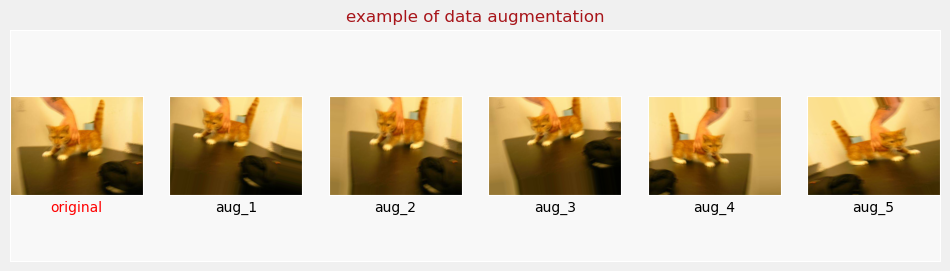

In [35]:
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts

fig = plt.figure('example of data augmentation', figsize=(12, 3))
plt.title('example of data augmentation')
plt.xticks([])
plt.yticks([])
fig.add_subplot(1, 6, 1)
plt.imshow(x/255)
plt.xlabel('original', color = 'r')
plt.xticks([])
plt.yticks([])
for i in range(5):
    for image in datagen_generator.next():
        fig.add_subplot(1, 6, i + 2)
        plt.imshow(image / 255.0)
        plt.xlabel(f'aug_{i + 1}')
        plt.xticks([])
        plt.yticks([])

### 4.1 define the aug_model with the same architecture with the base_model

In [36]:
inputs = Input(shape=input_shape)
aug_model = final_model(inputs)

In [37]:
# compile the aug_model
aug_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [38]:
epochs = 50
aug_model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/50


/var/folders/yh/_x7knk010_jf8mn6y34t0cnc0000gn/T/ipykernel_37972/2941456260.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  aug_model.fit_generator(
2022-10-11 17:49:43.820595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - ETA: 0s - loss: 1.5066 - accuracy: 0.5475

2022-10-11 17:49:50.790621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 9s 62ms/step - loss: 1.5066 - accuracy: 0.5475 - val_loss: 8.5215 - val_accuracy: 0.5000
Epoch 2/50
125/125 [==============================] - 8s 60ms/step - loss: 0.7188 - accuracy: 0.6050 - val_loss: 0.8188 - val_accuracy: 0.5962
Epoch 3/50
125/125 [==============================] - 7s 58ms/step - loss: 0.6880 - accuracy: 0.6135 - val_loss: 0.6627 - val_accuracy: 0.6062
Epoch 4/50
125/125 [==============================] - 7s 59ms/step - loss: 0.6562 - accuracy: 0.6570 - val_loss: 0.6997 - val_accuracy: 0.6187
Epoch 5/50
125/125 [==============================] - 8s 60ms/step - loss: 0.6027 - accuracy: 0.6920 - val_loss: 0.8546 - val_accuracy: 0.6425
Epoch 6/50
125/125 [==============================] - 7s 59ms/step - loss: 0.6252 - accuracy: 0.6820 - val_loss: 0.6379 - val_accuracy: 0.6975
Epoch 7/50
125/125 [==============================] - 7s 58ms/step - loss: 0.5853 - accuracy: 0.7040 - val_loss: 0.7627 - val_accuracy: 0.6750
Epoch 8/50

In [39]:
aug_model.save_weights('./models/aug_model.h5')

**Base model with data augmentation Performance**:
<table>
    <tr>
        <td>
            <b>training_accuracy</b>
        </td>
         <td>
            <b>validation_accuracy</b>
        </td>
    </tr>
    <tr>
        <td>
            <b>0.8655</b>
        </td>  
        <td>
            <b>0.7738</b>
        </td> 
    </tr>
</table>

**note here**
- `overfitting` is remedy somewhat and the validation accuract reach 80%
- the variance of the validation accuracy is fairly high, both because accuracy is a high-variance metric and because we only use 800 validation samples. A good validation strategy in such cases would be to do k-fold cross-validation, but this would require training k models for every evaluation round

## 5. Using the bottleneck features of a pre-trained network
- will use the VGG16 architecture, pre-trained on the ImageNet dataset 
1. only instantiate the convolutional part of the model, everything up to the fully-connected layers
2. run this model on our training and validation data once, recording the output (the "bottleneck features" from th VGG16 model: the last activation maps before the fully-connected layers) in two numpy arrays
3. Then we will train a small fully-connected model on top of the stored features.

The reason why we are storing the features offline rather than adding our fully-connected model directly on top of a frozen convolutional base and running the whole thing, is computational effiency.

In [40]:
VGG_model = applications.VGG16(include_top=False, weights='imagenet')

In [48]:
datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical',  # this means our generator will only yield batches of data, no labels
        shuffle=False) # dont shuffle it because we need to create label manually

bottleneck_features_train = VGG_model.predict(train_generator, nb_train_samples // batch_size)

# np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

test_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

bottleneck_features_validation = VGG_model.predict(test_generator, nb_validation_samples // batch_size)

# np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

Found 2000 images belonging to 2 classes.
125/125 [==============================] - 10s 80ms/step
Found 800 images belonging to 2 classes.
50/50 [==============================] - 4s 80ms/step


In [50]:
# train_data = np.load(open('bottleneck_features_train.npy'))
train_labels = np.array([[0, 1]] * (nb_train_samples // 2) + [[1, 0]] * (nb_train_samples // 2))
validation_labels = np.array([[0, 1]] * (nb_validation_samples // 2) + [[1, 0]] * (nb_validation_samples // 2))

In [52]:
# define the topping layer to train the bottleneck features
def top_layers(inputs):
    
    x = Flatten()(inputs)
    x = Dense(256, 'relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(2, 'sigmoid')(x)
    
    top_model = Model(inputs=inputs, outputs=x)
    return top_model

In [53]:
# get the bottleneck output as the input of the top_model
inputs = Input(shape=bottleneck_features_train.shape[1:])
top_model = top_layers(inputs)
top_model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
top_model.fit(bottleneck_features_train, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(bottleneck_features_validation, validation_labels))

Epoch 1/50


2022-10-11 18:00:00.711525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 2s 10ms/step - loss: 0.7384 - accuracy: 0.7720 - val_loss: 0.2619 - val_accuracy: 0.8912
Epoch 2/50


2022-10-11 18:00:01.988604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 1s 9ms/step - loss: 0.3533 - accuracy: 0.8490 - val_loss: 0.2991 - val_accuracy: 0.8737
Epoch 3/50
125/125 [==============================] - 1s 9ms/step - loss: 0.2995 - accuracy: 0.8920 - val_loss: 0.3981 - val_accuracy: 0.8450
Epoch 4/50
125/125 [==============================] - 1s 9ms/step - loss: 0.2612 - accuracy: 0.9010 - val_loss: 0.2487 - val_accuracy: 0.9025
Epoch 5/50
125/125 [==============================] - 1s 9ms/step - loss: 0.2227 - accuracy: 0.9245 - val_loss: 0.2766 - val_accuracy: 0.9000
Epoch 6/50
125/125 [==============================] - 1s 9ms/step - loss: 0.1910 - accuracy: 0.9320 - val_loss: 0.3703 - val_accuracy: 0.8812
Epoch 7/50
125/125 [==============================] - 1s 9ms/step - loss: 0.1822 - accuracy: 0.9325 - val_loss: 0.7302 - val_accuracy: 0.8125
Epoch 8/50
125/125 [==============================] - 1s 9ms/step - loss: 0.1538 - accuracy: 0.9450 - val_loss: 0.4582 - val_accuracy: 0.8600
Epoch 9/50
125/12

In [55]:
top_model.save_weights('./model_weights/VGG_bottleneck_top_model.h5')

**VGG model with bottleneck feature Performance**:
<table>
    <tr>
        <td>
            <b>training_accuracy</b>
        </td>
         <td>
            <b>validation_accuracy</b>
        </td>
    </tr>
    <tr>
        <td>
            <b>0.9975</b>
        </td>  
        <td>
            <b>0.8750</b>
        </td> 
    </tr>
</table>

**note here**
- `overfitting` is further remedy somewhat and the validation accuract reach 90%
-  This is definitely partly due to the fact that the base model was trained on a dataset that already featured dogs and cats (among hundreds of other classes).

## 6. Fine-tuning the top layers of a a pre-trained network
To further improve our previous result, we can try to "fine-tune" the last convolutional block of the VGG16 model alongside the top-level classifier

- instantiate the convolutional base of VGG16 and load its weights
- add our previously defined fully-connected model on top, and load its weights
- freeze the layers of the VGG16 model up to the last convolutional block

In [56]:
VGG_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
VGG_model.summary()
for layer in VGG_model.layers[:16]:
    layer.trainable = False

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [57]:
top_model = top_layers(VGG_model.output)
top_model.load_weights('./model_weights/VGG_bottleneck_top_model.h5')

In [58]:
def final_model():
    vgg_output = VGG_model.output
    outputs = top_model(vgg_output)
    
    vgg_final_model = Model(inputs=VGG_model.input, outputs=outputs)
    
    return vgg_final_model
    

In [59]:
vgg_final_model = final_model()
vgg_final_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [61]:
# training data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# validation data Augmentation
test_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [62]:
vgg_final_model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/50


/var/folders/yh/_x7knk010_jf8mn6y34t0cnc0000gn/T/ipykernel_37972/538421770.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg_final_model.fit_generator(
2022-10-11 18:01:48.017248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - ETA: 0s - loss: 1.7472 - accuracy: 0.6350

2022-10-11 18:02:00.132359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 16s 128ms/step - loss: 1.7472 - accuracy: 0.6350 - val_loss: 0.4803 - val_accuracy: 0.7775
Epoch 2/50
125/125 [==============================] - 16s 127ms/step - loss: 0.4621 - accuracy: 0.7860 - val_loss: 0.3908 - val_accuracy: 0.8425
Epoch 3/50
125/125 [==============================] - 16s 127ms/step - loss: 0.4304 - accuracy: 0.8005 - val_loss: 0.3496 - val_accuracy: 0.8687
Epoch 4/50
125/125 [==============================] - 16s 127ms/step - loss: 0.3683 - accuracy: 0.8350 - val_loss: 0.3145 - val_accuracy: 0.8762
Epoch 5/50
125/125 [==============================] - 16s 127ms/step - loss: 0.3142 - accuracy: 0.8805 - val_loss: 0.2862 - val_accuracy: 0.8875
Epoch 6/50
125/125 [==============================] - 16s 127ms/step - loss: 0.3041 - accuracy: 0.8750 - val_loss: 0.3147 - val_accuracy: 0.8625
Epoch 7/50
125/125 [==============================] - 16s 127ms/step - loss: 0.2987 - accuracy: 0.8720 - val_loss: 0.2615 - val_accuracy: 0.8

In [63]:
vgg_final_model.save_weights('./model_weights/vgg_final_model_fine_tune.h5')

**VGG model Performance after fine-tune**:
<table>
    <tr>
        <td>
            <b>training_accuracy</b>
        </td>
         <td>
            <b>validation_accuracy</b>
        </td>
    </tr>
    <tr>
        <td>
            <b>0.9875</b>
        </td>  
        <td>
            <b>0.9212</b>
        </td> 
    </tr>
</table>

**note here**

This approach gets us to a validation accuracy of 0.92 after 50 epochs.
Here are a few more approaches you can try to get higher accuracy:
- more aggresive data augmentation
- more aggressive dropout
- use of L1 and L2 regularization (also known as "weight decay")
- fine-tuning one more convolutional block (alongside greater regularization)

In [64]:
vgg_final_model.save("models/vgg_model.h5")

## 7. test the model

The `test` data includes 400 images for two classes

In [122]:
# test model
test_data = image_dataset_from_directory('./data/test/',
                                         shuffle=False,
                                         batch_size=batch_size,
                                         image_size=(img_width, img_height),
                                         label_mode='categorical',
                                        )

Found 400 files belonging to 2 classes.


In [123]:
def format_image(image, label):
    
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    
    return image, label

In [124]:
test_data = test_data.map(format_image)

In [126]:
result = vgg_final_model.evaluate(test_data)

25/25 [==============================] - 2s 84ms/step - loss: 0.1721 - accuracy: 0.9375


In [129]:
print(f'The performance on the test set \nloss: {result[0]}, accuracy: {result[1]}')

The performance on the test set 
loss: 0.17205654084682465, accuracy: 0.9375
